# Stock For Real
>created by vikky

In [1]:
import pandas as pd
# import matplotlib.pyplot as plt
import numpy as np
import os
import time
from datetime import datetime
from datetime import timedelta
from pyecharts import *
import warnings
warnings.filterwarnings('ignore')

### 读取文件

In [2]:
# path = '../stock_data/'
path = 'D:/work_documents/vikky_projects/python_project/stock_project/stockSpider/stock_data/'
file_name = os.listdir(path)[-1]
df = pd.read_csv(path+file_name,encoding="gbk")
#重新设置列名
df.columns = ["date","time","industry","industry_idx","chg","money_in","money_out","net","company_counts","lead_stock","lead_chg","lead_price"]

*字段注释：*   
*date:交易日期ime:交易时间  industry:行业  industry_idx:行业指数  chg:行业涨跌幅  money_in:流入资金(亿元) money_out:流出资金(亿元)*  
*net:净额(亿元)  company_counts:公司家数 lead_stock:领涨股  lead_chg:领涨股涨跌幅  lead_price:领涨股价格(元)*

In [5]:
# 查看字段信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118784 entries, 0 to 118783
Data columns (total 12 columns):
date              118784 non-null object
time              118784 non-null object
industry          118784 non-null object
industry_idx      118784 non-null float64
chg               118784 non-null object
money_in          118784 non-null float64
money_out         118784 non-null float64
net               118784 non-null float64
company_counts    118784 non-null int64
lead_stock        118784 non-null object
lead_chg          118784 non-null object
lead_price        118784 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 10.9+ MB


### 数据预处理

mark：数据预处理的工作量要比想象中的要大得多，在数据提取时虽然定义好了字段，但在后续的分析中出现了诸多问题：  
    1.同一时间点有重复记录，出现这种现象的原因是在原网页中行业资金流向是分页的，详见http://data.10jqka.com.cn/funds/hyzjl/ ，两页的数据更新不
     同步，解决方法是获取排序后的数据  
    2.在解决上一问题后又出现了新的问题--因为数据是通过ajax请求获取的，在重复提交同一ajax请求时，数据不会更新（可能是因为网页缓存原因），折腾
     了很久，最后通过在请求的ajax url中加上时间戳解决了此问题  
    3.在一开始定义提取字段时，只有一个时间字段（包含日期和时间）。当想分析每日最终的资金流向情况时，只需要每一天15：00（即交易截止的时间点）
     的数据。通过DataFrame的groupby函数可以获取按照日期（日期根据时间字段新增）、时间分组的有二层index的分组表
     ![实例](./picture/1.png)
     这样还是有些不方便，最后选择改变数据提取的字段，将日期和时间分成两个字段，方便数据提取

### 数据分析

* **股市总体情况**

>下面的语句是取出每天收盘时间点（15:00）的行业资金流动数据并按照日期进行分组，并将查询到的数据结构保存在daily_money变量中，这里没有对daily_money 应用sum()是因为有部分指标不适用与sum(),比如行业指数（industry_idx从下面的示例也可以看到industry_idx经过sum()后数值很大，也没有参考价值

In [3]:
#get daily money
daily_money = df[df['time']=='15:00'].groupby('date').sum().reset_index()[['date','money_in','money_out','net']]
timeline = daily_money.date
money_in = daily_money.money_in
money_out = daily_money.money_out
net = daily_money.net
bar = Bar('股市总体情况',width=980,height=330)
bar.add('流入资金',timeline,money_in,is_smooth=True,is_datazoom_show=True)
bar.add('流出资金',timeline,money_out,is_datazoom_show=True)
bar.add('净额',timeline,net,is_datazoom_show=True)
bar

* 当日实时资金流动情况  
    这里展示的是当天实时的资金流入/流出/净额 情况

In [5]:
daily_money = df.loc[df['date']=='2018-02-05',['time','money_in','money_out','net']].groupby('time').sum().reset_index()
timeline = daily_money.index
money_in = daily_money.money_in
money_out = daily_money.money_out
net = daily_money.net
line = Line('当天资金流动情况',width=1000,height=330)
line.add('流入资金',timeline,money_in,is_smooth=True)
line.add('流出资金',timeline,money_out,is_smooth=True)
line.add('净额',timeline,net,is_smooth=True)
line

* 查看近15天某行业的资金流动情况

In [6]:
daily_money = df.loc[(df['industry']=='银行')&(df['time']=='15:00'),['date','net','money_in','money_out']][-15:].set_index('date')
timeline = daily_money.index
money_in = daily_money.money_in
money_out = daily_money.money_out
net = daily_money.net
bar = Bar('近15天某行业的资金流动情况',width=1000,height=330)
bar.add('流入资金',timeline,money_in,is_smooth=True, mark_point=["min"])
bar.add('流出资金',timeline,money_out, mark_point=["min"])
bar.add('净额',timeline,net,mark_line=["average"])
bar

* 近15天流入资金/流出资金/净额TOP15行业

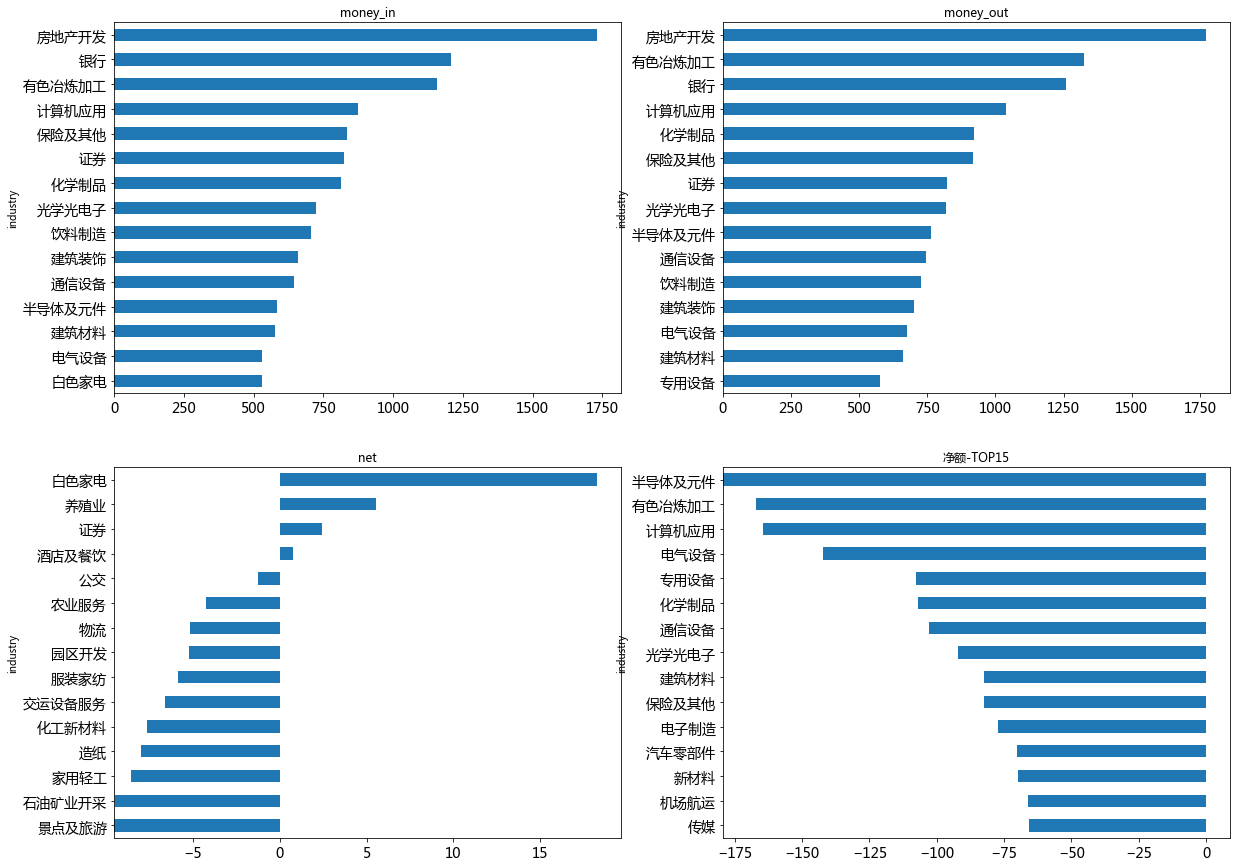

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
df.loc[(df['time']=='15:00')&(df['date']>=str(datetime.date(datetime.now()-timedelta(15))))]\
.groupby('industry').sum().sort_values('money_in',ascending=1)['money_in'][-15:].plot(kind='barh',fontsize=14,subplots=True,ax=axes[0][0])
plt.title('流入资金TOP15')
df.loc[(df['time']=='15:00')&(df['date']>=str(datetime.date(datetime.now()-timedelta(15))))]\
.groupby('industry').sum().sort_values('money_out',ascending=1)['money_out'][-15:].plot(kind='barh',fontsize=14,subplots=True,ax=axes[0][1])
plt.title('流出资金TOP15')
df.loc[(df['time']=='15:00')&(df['date']>=str(datetime.date(datetime.now()-timedelta(15))))]\
.groupby('industry').sum().sort_values('net',ascending=1)['net'][-15:].plot(kind='barh',fontsize=14,subplots=True,ax=axes[1][0])
plt.title('净额TOP15')
df.loc[(df['time']=='15:00')&(df['date']>=str(datetime.date(datetime.now()-timedelta(15))))]\
.groupby('industry').sum().sort_values('net',ascending=0)['net'][-15:].plot(kind='barh',fontsize=14,subplots=True,ax=axes[1][1])
plt.title('净额-TOP15')

* **industry money flow**

注意到，源表是根据时间序列生成各个行业的资金流向（即每个时间点会生成66个行业的资金流向数据），为了分析各个行业的资金流动变化情况，需要对源表进行转变，使用pandas.pivot()/pandas.pivot_table()可以从原表派生出符合格式的表。

In [7]:
# path = '../stock_data/'
path = 'D:/work_documents/vikky_projects/python_project/stock_project/stockSpider/stock_data/'
file_name = os.listdir(path)[-1]
df = pd.read_csv(path+file_name,encoding="gbk")
#重新设置列名
df.columns = ["date","time","industry","industry_idx","chg","money_in","money_out","net","company_counts","lead_stock","lead_chg","lead_price"]
industry_df = df.pivot_table(index=['date','time'],columns='industry',values=['net','money_in','money_out']).reset_index()
industry_df['timeline'] = industry_df.date+'-'+industry_df.time
industry_df.drop(['date','time'],axis=1,inplace=True)
industry_df.set_index('timeline',inplace=True)

* 行业清单    
专用设备 中药 交运设备服务 仪器仪表 传媒 保险及其他 光学光电子 公交 公路铁路运输 其他电子 养殖业 农业服务 农产品加工 包装印刷  
化学制品 化学制药 化工合成材料 化工新材料 医疗器械服务 医药商业  
半导体及元件 园区开发 国防军工 基础化学 家用轻工  建筑材料 建筑装饰 房地产开发 新材料  
景点及旅游 有色冶炼加工 服装家纺 机场航运 汽车整车 汽车零部件 港口航运  
煤炭开采 燃气水务 物流 环保工程 生物制品 电力 电子制造 电气设备 白色家电 石油矿业开采 种植业与林业 纺织制造 综合 视听器材  
计算机应用 计算机设备 证券 贸易 通信服务 通信设备 通用设备 造纸 酒店及餐饮 采掘服务 钢铁 银行 零售 非汽车交运 食品加工制造 饮料制造

In [8]:
industry = '专用设备'
days = 20
daily_money = industry_df[-int(56*days):]  #一天56条记录
timeline = daily_money.index
money_in = daily_money.money_in[industry]
money_out = daily_money.money_out[industry]
net = daily_money.net[industry]
bar = Bar('当天资金流动情况',width=980,height=330)
bar.add('流入资金',timeline,money_in,is_datazoom_show=True)
bar.add('流出资金',timeline,money_out,is_datazoom_show=True)
bar.add('净额',timeline,net,is_datazoom_show=True)
bar

* 行业实时资金占比

In [16]:
current_money_net = round(industry_df.tail(1).net.sum(axis=1),2)
industry_current_money_net = industry_df.tail(1).net[industry]
current_money_money_in = round(industry_df.tail(1).money_in.sum(axis=1),2)
industry_current_money_money_in = industry_df.tail(1).money_in[industry]
current_money_money_out = round(industry_df.tail(1).money_out.sum(axis=1),2)
industry_current_money_money_out = industry_df.tail(1).money_out[industry]
schema = ["净额", "流入资金", "流出资金"]
parallel = Parallel("实时资金对比",width=980,height=330)
parallel.config(schema)
parallel.add("股市", [[current_money_net,current_money_money_in,current_money_money_out]],is_label_show=True)
parallel.add(industry, [[industry_current_money_net,industry_current_money_money_in,industry_current_money_money_out]],is_label_show=True)
parallel

* 金融行业资金流向趋势

In [9]:
from random import randint
from pyecharts import *

WIDTH=900
HEIGHT=500
every_industry_flow = industry_df[industry_df.timeline.index.str.startswith(max(df.date))]
def create_charts():
    page = Page()
    industry = every_industry_flow.net.columns #行业
    industry_net = every_industry_flow.net #净额
    industry_money_in = every_industry_flow.money_in #流入资金
    industry_money_out = every_industry_flow.money_out #流入资金
    bar_industry = []
    for i in range(industry_net.shape[0]):#industry_net.shape[0]
        bar = Bar("各行业资金流动时间线",background_color="gray")#,background_color="gray",
        for j in industry:
            bar.add(j, ['净额','流入资金','流出资金'], [industry_net[j][i],industry_money_in[j][i],industry_money_out[j][i]],\
                    is_visualmap=0,is_roam=1,area_color="gray", tooltip_formatter='{c}',grid_top=100)
        bar_industry.append(bar)
    chart = Timeline(is_auto_play=0, timeline_bottom=0,
                     width=WIDTH, height=HEIGHT)
    for i in range(industry_net.shape[0]):
        chart.add(bar_industry[i], every_industry_flow.index[i].split("-")[-1])
    page.add(chart)
  
    return page
create_charts()

[<pyecharts.custom.timeline.Timeline at 0x4b16550>]

* 资源开采类行业资金流向趋势

* 医疗相关行业资金流向趋势